## Gradient-descent quantum process tomography and benchmarks

In this notebook, we demonstrate how the quantum process tomography task can
be performed using gradient-based learning of Kraus operators similar to
training neural networks. We consider random discrete-variable quantum processes
and gradient-descent QPT (GD-QPT) against compressed sensing (CS).

In [1]:
import sys
import os

from functools import partial


import numpy as np


import scipy as sp
from scipy import stats


from qutip import Qobj, fidelity, ket2dm, qeye, sigmax, sigmay, sigmaz
from qutip.superop_reps import kraus_to_choi
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qutip.visualization import hinton


from tqdm.auto import tqdm
from tqdm import trange


import jax
from jax import numpy as jnp
from jax import jit, vmap, grad
from jax.config import config


import cvxpy as cp


from matplotlib import pyplot as plt
import matplotlib.colors as colors

from gd_qpt.core import (tensor_product_list, convert_to_jax, prod_pauli_vecs,
                         probas_pauli)
from gd_qpt.cs import get_sensing_matrix, CompressedSensing
from gd_qpt.gd import predict, get_block, get_unblock, stiefel_update


config.update("jax_enable_x64", True)

### Generate a set of random Kraus operators from random unitaries

In [2]:
# number of qubits
n = 2 

# Rank of process and number of Kraus operators
rank = 16
num_kraus = 16

# Hilbert space dimension
N = 2**n


def random_kraus(N, weights, rank, density=0.5):
    """Generates a sum of random unitaries to form a process given a set of
    weights and the rank of the process.

    Args:
        N (int): Hilbert space dimension.
        weights (array): Random weights that will be normalized.
        rank (int): The rank of the process.
        density (float): A number between 0, 1 to specifying the density of the
                         random unitaries.

    Returns:
        kraus_ops (array): A (k x N x N) complex-valued array of Kraus operators.
    """
    weights_unnormalized = weights**np.arange(rank)
    weights = weights_unnormalized / (weights_unnormalized).sum()
    kraus_ops = np.array([np.sqrt(w)*rand_unitary(N, density=density) for w in weights])
    return kraus_ops


kraus_true = random_kraus(N, np.random.uniform(0.1, 1.), rank)

### Convert to the Choi matrix and visualize the Choi matrix

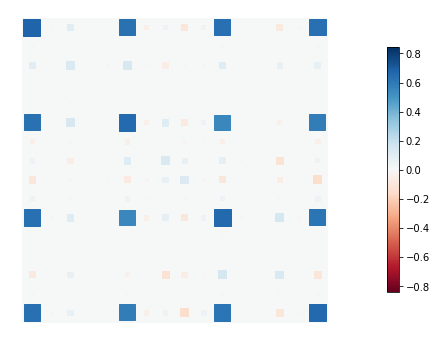

In [3]:
def choi(kraus_ops):
    """Takes the Kraus reprensentation of a channel and returns the Choi matrix.

    Args:
        kraus_ops (np.ndarray): The (k, N, N)-array representing k Kraus ops.

    Returns:
        np.array: A (N^2, N^2) array representing the Choi matrix.
    """
    r, N, N = kraus_ops.shape
    vectorized_kraus = kraus_ops.reshape(r, N ** 2)
    return np.einsum("ij, il -> jl", vectorized_kraus, vectorized_kraus.conj())



kraus_true = random_kraus(N, np.random.uniform(0.1, 1.), rank)
choi_qutip_test = kraus_to_choi([Qobj(kop) for kop in kraus_true])
choi_true = choi(kraus_true)# choi_qutip.full()
choi_qutip = Qobj(choi_true, dims=choi_qutip_test.dims, superrep="choi")


hinton(choi_true)
plt.show()

### Generate the Pauli-basis operators that act as probes and measurement ops

In [4]:
s2 = np.sqrt(0.5)

X, X_  = ket2dm(Qobj(np.array([s2+ 0j, s2+ 0j]))), ket2dm(Qobj(np.array([s2+ 0j, -s2+ 0j])))
Y, Y_  = ket2dm(Qobj(np.array([s2, s2*1j]))), ket2dm(Qobj(np.array([s2, -s2*1j])))
Z, Z_  = ket2dm(Qobj(np.array([1. + 0j, 0. + 0j]))), ket2dm(Qobj(np.array([0.+ 0j, 1.+ 0j])))

pauli_basis = tensor_product_list([Z, Z_, X, X_, Y, Y_], repeat=n)
pauli_basis = convert_to_jax(pauli_basis)

### Generate the sensing matrix from Pauli operators

In [5]:
S = get_sensing_matrix(pauli_basis, pauli_basis)
S = S.reshape(-1, S.shape[2])
print(S.shape)

(1296, 256)


### Generate the probabilites for different measurements and add noise to form the data

/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


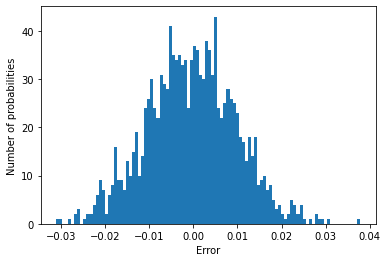

In [6]:
probabilities = S@(choi_qutip.full().T).ravel()

order = 100
data = probabilities + np.random.normal(0, 1/order, size=probabilities.shape[0])

plt.hist(data.ravel() - probabilities.ravel(), bins=100)
plt.xlabel("Error")
plt.ylabel("Number of probabilities")
plt.show()

### Apply compressed sensing to reconstruct the process from noisy data

In [7]:
model = CompressedSensing(dim=4**n)
choi_cs = model.fit(S, data)
choi_cs_qutip = Qobj(choi_cs, superrep="choi", dims=choi_qutip.dims)

/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/qutip/qobj.py:530: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


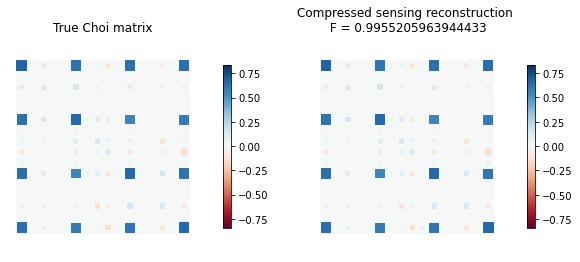

In [8]:
cs_fidelity =  fidelity(choi_cs_qutip/2**n, choi_qutip/2**n)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
hinton(choi_cs, ax=ax[1])
hinton(choi_true, ax=ax[0])

ax[0].set_title("True Choi matrix")
ax[1].set_title(f"Compressed sensing reconstruction \n F = {cs_fidelity}")

plt.show()

### Gradient descent QPT

Note that we generate the same probabilities as before but the ordering of the
Pauli matrices is a bit different that leads to reshuffling of the order of the
probabilities from the CS example. We use the predict function that takes in a
set of Kraus operators, probes and measurements to generate probabilities and
test it against the `probas_pauli` function from the PLS paper:
https://github.com/Hannoskaj/Hyperplane_Intersection_Projection

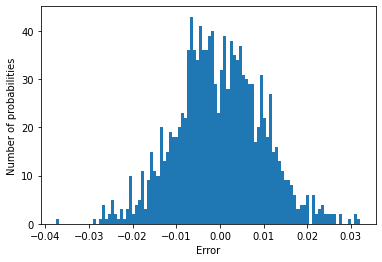

In [9]:
Pk = prod_pauli_vecs(n)
probas = probas_pauli(n, kraus_true)

np.testing.assert_array_almost_equal(probas, predict(kraus_true, Pk, Pk))

# Add noise to the data
data = probas + np.random.normal(0, 1/order, size=probas.shape)
plt.hist(data.ravel() - probas.ravel(), bins=100)
plt.xlabel("Error")
plt.ylabel("Number of probabilities")
plt.show()


### Random initialization of Kraus operators and gradient-descent on the Stiefel manifold

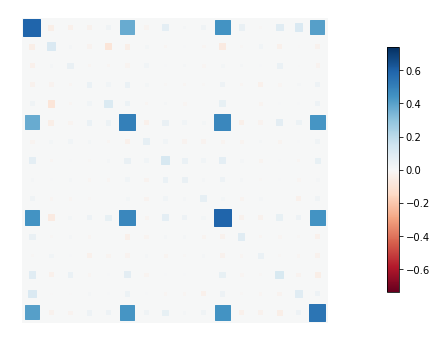

In [10]:
params_init = jnp.array([rand_unitary(N, density=0.5).full()/np.sqrt(num_kraus) for w in range(num_kraus)])
params = get_block(params_init)

choi_initial_qutip = kraus_to_choi([Qobj(np.array(kop)) for kop in params_init])
choi_initial = choi_initial_qutip.full()

hinton(choi_initial)
plt.show()

### Loss function

In [11]:
@partial(jit, static_argnums=4)
def loss(params, data=None, probes=None, measurements=None, num_kraus=None):
    """Loss function for the training assuming a predict function that can 
    generate probabilities for a measurement from the given process representation
    captured in params.

    Args:
        params (array): Parameters to optimize, e.g., Kraus operators.
        data (array): Data representing measured probabilities.
        probes (array): The probe operators.
        measurements (array): The measurement operators as Pauli vectors.
        num_kraus (int): The number of Kraus operators.

    Returns:
        loss (float): A scalar loss
    """
    k_ops = get_unblock(params, num_kraus)
    data_pred = predict(k_ops, probes, measurements)

    l2 = jnp.sum(((data - data_pred)**2))
    return l2 + 0.01*jnp.linalg.norm(params, ord=1)


print(loss(params, data, Pk, Pk, num_kraus))

11.505149187245712


### Loss gradients using batches of probes and measurements

In [12]:
def generate_batch(batch_size, len_indices):
    """Generates random indices to select a batch of the data 
        (probes x measurements) assuming same number of probes and measurements

    Args:
        batch_size (int): Batch size
        len_indices (int): Length of training data 
                          (probes and measurements are assumed to be the same)

    Returns:
        idx : A meshgrid of indices for selecting the data.
        idx1, idx2 (array): Indices for the probes and measurements.
    """
    idx1, idx2 = np.random.randint(0, len_indices, size=[2, batch_size])
    idx = tuple(np.meshgrid(idx1, idx2))
    return idx, idx1, idx2


batch_size = 32
idx, idx1, idx2 = generate_batch(batch_size, len(Pk))

### Compute the retraction and update parameters on the Stiefel manifold

In [13]:
grads = jax.grad(loss)(params, data.T[idx].real, Pk[idx1], Pk[idx2], num_kraus)
grads = jnp.conj(grads)
updated_params = stiefel_update(params, grads, 0.00001)

### Run gradient descent using batches of data

In [14]:
lr = 0.1
alpha = 0.999
loss_hist = []

for step in trange(1000): # pbar:
    idx, idx1, idx2 = generate_batch(batch_size, len(Pk))
    grads = jax.grad(loss)(params, data.T[idx].real, Pk[idx1], Pk[idx2], num_kraus=num_kraus)
    grads = jnp.conj(grads)
    grads = grads/jnp.linalg.norm(grads)

    params = stiefel_update(params, grads, lr)
    lr = alpha*lr

    lval = loss(params, data.T[idx].real, Pk[idx1], Pk[idx2], num_kraus=num_kraus)
    loss_hist.append(lval)

100%|██████████| 1000/1000 [00:05<00:00, 169.85it/s]


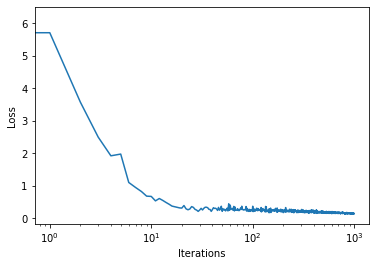

In [15]:
plt.semilogx(loss_hist)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [16]:
k_ops = get_unblock(params, num_kraus)

choi_gd = choi(k_ops)
choi_gd_qutip = Qobj(choi_gd, dims=choi_qutip.dims, superrep="choi")

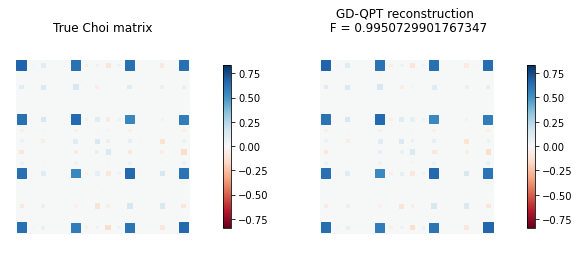

In [17]:
gd_fidelity =  fidelity(choi_gd_qutip/2**n, choi_qutip/2**n)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
hinton(choi_true, ax=ax[0])
hinton(choi_gd, ax=ax[1])

ax[0].set_title("True Choi matrix")
ax[1].set_title(f"GD-QPT reconstruction \n F = {gd_fidelity}")

plt.show()